<a href="https://colab.research.google.com/github/NathanRoland/Machine_Learning_Classifiers_Project/blob/main/COMP5318_assignment2_template_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4318/5318 Assignment 2: Image Classification

### Group number: 73  , SID1: 520510542 , SID2: 520131808, SID3: 510458096, SID4: 550749464

## Steps on how to run


1.   Load up google colab or run in any environment that utilises GPUs (for time reason)
2.   Run setup and depenedences and first cell under **Data loading, exploration, and preprocessing**
3. Run cells **Random Forest Classifier Preprocessing** and **Neural Network/Convolutional Neural Network Preprocessing**
4. Run all cells under the Algorithm design and setup
5. Run all cells in final models if you want analysis, otherwise, run every non analysis cell



## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
!pip install -q keras-tuner
import keras_tuner as kt
from keras.callbacks import EarlyStopping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [ ]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

#data exploration
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}\n")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Classes: {np.unique(y_train)}")
print(f"Training set size: {len(X_train)} images")
print(f"Test set size: {len(X_test)} images")

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nClass distribution in training set:")
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({100*count/len(y_train):.1f}%)")

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Training labels shape: (50000,)
Test labels shape: (10000,)

Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
Training set size: 50000 images
Test set size: 10000 images

Class distribution in training set:
  Class 0: 5000 samples (10.0%)
  Class 1: 5000 samples (10.0%)
  Class 2: 5000 samples (10.0%)
  Class 3: 5000 samples (10.0%)
  Class 4: 5000 samples (10.0%)
  Class 5: 5000 samples (10.0%)
  Class 6: 5000 samples (10.0%)
  Class 7: 5000 samples (10.0%)
  Class 8: 5000 samples (10.0%)
  Class 9: 5000 samples (10.0%)


### Sample Images

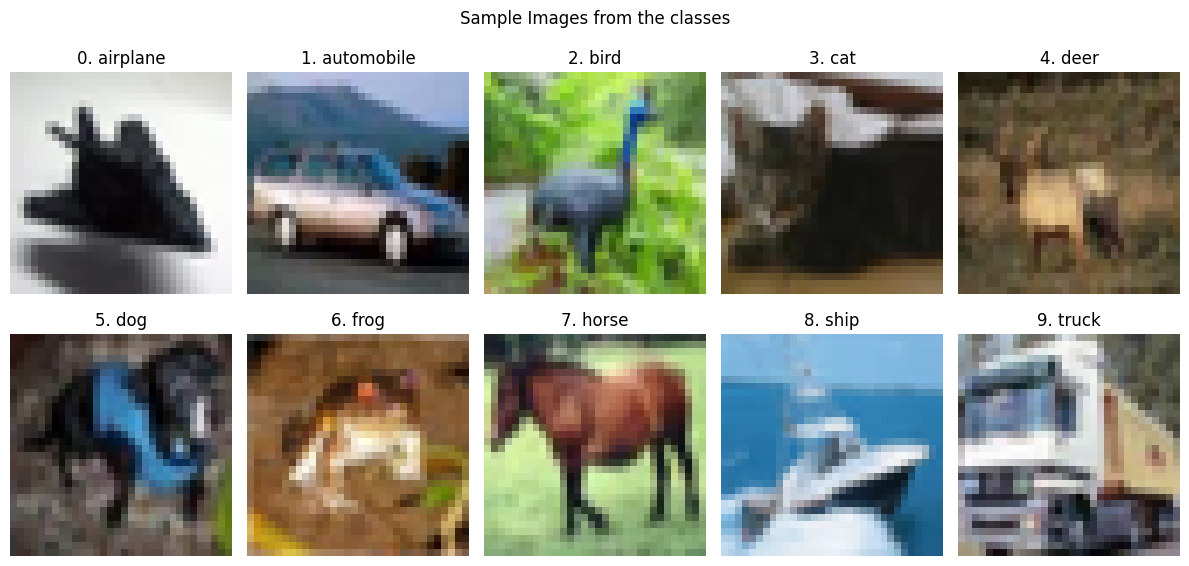

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Images from the classes")

for i in range(10):
  index = np.where(y_train == i)[0][0]
  img = X_train[index]
  ax = axes[i // 5, i % 5]
  ax.imshow(img)
  ax.set_title(str(str(i)+". "+class_names[i]))
  ax.axis('off')

plt.tight_layout()
plt.show()

### Characterisitcs of each image

In [ ]:
#characteristics of each class(image centering)

def image_centre(images, class_name):
  centers_y = []
  centers_x = []
  for img in images[:100]:
      gray = np.mean(img, axis=2)
      total = gray.sum()
      if total > 0:
          y_coords, x_coords = np.mgrid[0:32, 0:32]
          centers_y.append((gray * y_coords).sum() / total)
          centers_x.append((gray * x_coords).sum() / total)
  mean_y = np.mean(centers_y)
  mean_x = np.mean(centers_x)
  std_y = np.std(centers_y)
  std_x = np.std(centers_x)
  deviation = np.sqrt((mean_y - 16)**2 + (mean_x - 16)**2)
  return mean_y, mean_x, std_y, std_x, deviation

#ideal is 16,16
print("\nCenter of Mass Analysis:")
print(f"{'Class':<15} {'Mean Y':<10} {'Mean X':<10} {'Std Y':<10} {'Std X':<10} {'Deviation'}")

for class_idx, class_name in enumerate(class_names):
  class_images = X_train[y_train == class_idx]
  mean_y, mean_x, std_y, std_x, deviation = image_centre(class_images, class_name)
  print(f"{class_name:<15} {mean_y:>9.2f} {mean_x:>9.2f} {std_y:>9.2f} {std_x:>9.2f} {deviation:>9.2f}")


Center of Mass Analysis:
Class           Mean Y     Mean X     Std Y      Std X      Deviation
airplane            14.83     15.41      1.43      0.51      1.31
automobile          14.69     15.45      1.79      0.92      1.42
bird                15.29     15.47      1.36      0.96      0.89
cat                 15.39     15.51      1.40      1.25      0.78
deer                15.85     15.57      1.84      0.85      0.46
dog                 16.10     15.59      1.49      1.30      0.42
frog                15.70     15.63      1.44      0.87      0.48
horse               15.33     15.41      1.99      0.88      0.89
ship                14.10     15.43      1.55      0.90      1.98
truck               13.82     15.51      1.54      1.11      2.24


### Size of each image

In [ ]:
#size of different features

for class_idx, class_name in enumerate(class_names):
  class_images = X_train[y_train == class_idx][:100]
  variances = [np.var(img) for img in class_images]
  mean_variance = np.mean(variances)
  mean_brightness = np.mean(class_images)
  color_std = np.mean([np.std(img, axis=2).mean() for img in class_images])
  print("Class:", class_name)
  print("Mean Variance:", mean_variance)
  print("Mean Brightness:", mean_brightness)
  print("Color Diversity:", color_std,"\n")

Class: airplane
Mean Variance: 2953.456551309162
Mean Brightness: 146.470322265625
Color Diversity: 13.733038548776962 

Class: automobile
Mean Variance: 3838.8209312375384
Mean Brightness: 114.73344401041666
Color Diversity: 13.114607542366725 

Class: bird
Mean Variance: 2177.6417688740626
Mean Brightness: 121.291416015625
Color Diversity: 15.537763784818397 

Class: cat
Mean Variance: 3032.7971148342554
Mean Brightness: 117.45211588541666
Color Diversity: 14.40034690871864 

Class: deer
Mean Variance: 2278.3751668739314
Mean Brightness: 109.16088541666667
Color Diversity: 17.15305591987467 

Class: dog
Mean Variance: 3215.7219190777673
Mean Brightness: 112.447939453125
Color Diversity: 12.7923379930241 

Class: frog
Mean Variance: 2413.0300294017793
Mean Brightness: 104.12030924479167
Color Diversity: 16.629396113970373 

Class: horse
Mean Variance: 3382.810214408239
Mean Brightness: 116.08701497395833
Color Diversity: 15.04185806068151 

Class: ship
Mean Variance: 3373.467964172363

### Pixel intensity across different images

In [ ]:
#pixel intensities across different images

for index, name in enumerate(class_names):
  class_images = X_train[y_train == index]
  mean_intensity = class_images.mean(axis=(1, 2))
  std_intensity = class_images.std(axis=(1, 2))
  print(f"Class {name}: Mean Intensity: {mean_intensity.mean():.2f}, Std Intensity: {std_intensity.mean():.2f}")


Class airplane: Mean Intensity: 142.37, Std Intensity: 48.28
Class automobile: Mean Intensity: 116.70, Std Intensity: 59.14
Class bird: Mean Intensity: 119.41, Std Intensity: 42.74
Class cat: Mean Intensity: 116.23, Std Intensity: 53.11
Class deer: Mean Intensity: 111.78, Std Intensity: 41.64
Class dog: Mean Intensity: 117.39, Std Intensity: 53.24
Class frog: Mean Intensity: 106.56, Std Intensity: 43.71
Class horse: Mean Intensity: 118.89, Std Intensity: 54.34
Class ship: Mean Intensity: 133.48, Std Intensity: 53.19
Class truck: Mean Intensity: 124.28, Std Intensity: 62.62


### Key differences between classes

In [ ]:
#key differences between classes
class_rgb_profiles = []

for class_idx, class_name in enumerate(class_names):
    class_images = X_train[y_train == class_idx]

    mean_r = class_images[:, :, :, 0].mean()
    mean_g = class_images[:, :, :, 1].mean()
    mean_b = class_images[:, :, :, 2].mean()

    class_rgb_profiles.append({
        'Class': class_name,
        'Red': mean_r,
        'Green': mean_g,
        'Blue': mean_b,
        'Overall': (mean_r + mean_g + mean_b) / 3
    })

rgb_df = pd.DataFrame(class_rgb_profiles)

print("\nAverage RGB Values by Class:")
print("-"*70)
print(rgb_df.to_string(index=False, float_format='%.2f'))


Average RGB Values by Class:
----------------------------------------------------------------------
     Class    Red  Green   Blue  Overall
  airplane 134.04 142.88 150.17   142.37
automobile 120.15 115.91 114.04   116.70
      bird 124.76 125.33 108.13   119.41
       cat 126.35 116.39 105.96   116.23
      deer 120.26 118.63  96.44   111.78
       dog 127.48 118.48 106.22   117.39
      frog 119.86 111.79  88.03   106.56
     horse 128.00 122.37 106.31   118.89
      ship 125.01 133.98 141.44   133.48
     truck 127.16 123.76 121.91   124.28


### Random Forest Classifier Preprocessing

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Flatten
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattening:")
print(f"Original shape: {X_train.shape} → Flattened: {X_train_flat.shape}")
print(f"Each image: 32×32×3 = {X_train_flat.shape[1]} features\n")

#Normalise
X_train_normalized = X_train_flat.astype('float32') / 255.0
X_test_normalized = X_test_flat.astype('float32') / 255.0

print(f"Normalization:")
print(f"Original range: [{X_train_flat.min()}, {X_train_flat.max()}]")
print(f"Normalized range: [{X_train_normalized.min():.2f}, {X_train_normalized.max():.2f}]")

Flattening:
Original shape: (50000, 32, 32, 3) → Flattened: (50000, 3072)
Each image: 32×32×3 = 3072 features

Normalization:
Original range: [0, 255]
Normalized range: [0.00, 1.00]


### Neural Network/Convolutional Neural Network Preprocessing

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Normalisation
X_train_nn = X_train.astype('float32') / 255.0
X_test_nn = X_test.astype('float32') / 255.0
print(f"Normalization:")
print(f"Original range: [0, 255]")
print(f"Normalized range: [{X_train_nn.min():.2f}, {X_train_nn.max():.2f}]")
print(f"Shape preserved: {X_train_nn.shape} (for CNN compatibility)\n")

#validation split
X_train_mlp, X_valid_mlp, y_train_mlp, y_valid_mlp = train_test_split(X_train_nn, y_train, train_size=0.9, random_state=42)

print(f"Train/Validation Split:")
print(f"Training set: {X_train_mlp.shape[0]:,} samples (90%)")
print(f"Validation set: {X_valid_mlp.shape[0]:,} samples (10%)")
print(f"Test set: {X_test_nn.shape[0]:,} samples (held out)")

Normalization:
Original range: [0, 255]
Normalized range: [0.00, 1.00]
Shape preserved: (50000, 32, 32, 3) (for CNN compatibility)

Train/Validation Split:
Training set: 45,000 samples (90%)
Validation set: 5,000 samples (10%)
Test set: 10,000 samples (held out)


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course: Random Forest Classifier

In [ ]:
subset_size = 10000
X_train_subset = X_train_normalized[:subset_size]
y_train_subset = y_train[:subset_size]
start_time = time.time()

rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10, min_samples_leaf=4, random_state=42, verbose=1)
rf_baseline.fit(X_train_subset, y_train_subset)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds\n")

train_pred = rf_baseline.predict(X_train_normalized)
test_pred = rf_baseline.predict(X_test_normalized)
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"Baseline Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")





[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   28.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   56.0s finished



Training completed in 56.05 seconds



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Baseline Results:
Training Accuracy: 0.5306
Test Accuracy: 0.4242


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


### Fully connected neural network

In [ ]:
def build_fc_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=[32, 32, 3]))
  model.add(keras.layers.Flatten())
  num_layers = hp.Choice('num_layers', values=[1, 2])

  for i in range(1, num_layers + 1):
      units = hp.Choice(f'units_{i}', values=[128, 256, 512])
      activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
      model.add(keras.layers.Dense(units=units, activation=activation))
      dropout_rate = hp.Choice(f'dropout_{i}', values=[0.2, 0.3, 0.4])
      model.add(keras.layers.Dropout(dropout_rate))

  model.add(keras.layers.Dense(10, activation='softmax'))
  learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

print("Testing Fully Connected Neural Network runs")
test_model = build_fc_model(kt.HyperParameters())
print(f"Summary: {test_model.summary()}")
print(f"Total parameters: {test_model.count_params()}")

mlp_tuner = kt.RandomSearch(
    build_fc_model,
    objective='val_accuracy',
    max_trials=20,
    directory='mlp_tuning',
    project_name='cifar10_mlp',
    overwrite=True
)


Testing Fully Connected Neural Network runs


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Summary: None
Total parameters: 394634


### Convolutional neural network

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
])

def build_cnn_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(32, 32, 3)))
  model.add(data_augmentation)

  filters = [32, 64, 128]
  for i, f in enumerate(filters):
      model.add(keras.layers.Conv2D(f, (3,3), activation='relu', padding='same'))
      model.add(keras.layers.Conv2D(f, (3,3), activation='relu', padding='same'))
      model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
      model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.GlobalAveragePooling2D())
  dense_units = hp.Choice('dense_units', [256, 512])
  model.add(keras.layers.Dense(dense_units, activation='relu'))
  dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4, 0.5])
  model.add(keras.layers.Dropout(dropout_rate))

  model.add(keras.layers.Dense(10, activation='softmax'))
  learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

print("Testing Convolutional neural network runs")
test_model = build_cnn_model(kt.HyperParameters())
print(f"Total parameters: {test_model.count_params():,}")
print(f"Summary: {test_model.summary()}")
print(f"Total parameters: {test_model.count_params()}")
cnn_tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=20,
    directory='cnn_tuning_enhanced',
    project_name='cifar10_cnn',
    overwrite=True
)

Testing Convolutional neural network runs
Total parameters: 323,498


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,498 (1.23 MB)

 Trainable params: 323,050 (1.23 MB)

 Non-trainable params: 448 (1.75 KB)

Summary: None
Total parameters: 323498


## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course: Random Forest Classifier

In [ ]:
def tunedRFClassifier(X_train_subset, y_train_subset):
  param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [10, 20, 30, None],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'max_features': ['sqrt', 'log2']
  }

  rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

  halving_search = HalvingGridSearchCV(
      estimator=rf_classifier,
      param_grid=param_grid,
      factor=3,
      resource='n_samples',
      max_resources=len(X_train_subset),
      cv=3,
      scoring='balanced_accuracy',
      verbose=2,
      n_jobs=-1,
      return_train_score=True
  )

  print("Starting HalvingGridSearchCV...")
  start_time = time.time()
  halving_search.fit(X_train_subset, y_train_subset)
  tuning_time = time.time() - start_time

  best_params = halving_search.best_params_
  best_score = halving_search.best_score_

  print(f"\nHalving Grid Search completed in {tuning_time/60:.2f} minutes")
  print(f"Best Balanced CV Accuracy: {best_score:.4f}")
  print("Best Parameters Found:")
  for k, v in best_params.items():
      print(f"  {k}: {v}")

  results_df = pd.DataFrame(halving_search.cv_results_)
  return best_params, best_score, results_df, tuning_time

best_params_rf, best_cv_score_rf, rf_results_df, tuning_time = tunedRFClassifier(X_train_subset, y_train_subset)

Starting HalvingGridSearchCV...
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 246
max_resources_: 20000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 216
n_resources: 246
Fitting 3 folds for each of 216 candidates, totalling 648 fits
----------
iter: 1
n_candidates: 72
n_resources: 738
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 2
n_candidates: 24
n_resources: 2214
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 8
n_resources: 6642
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 19926
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Halving Grid Search completed in 93.89 minutes
Best Balanced CV Accuracy: 0.4431
Best Parameters Found:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300


### Analysis of RF Classifier Hyperparameter tuning


Rank 1:
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean CV Accuracy: 0.4431 
Mean Training Time: 466.30s

Rank 2:
Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean CV Accuracy: 0.4395 
Mean Training Time: 355.74s

Rank 3:
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean CV Accuracy: 0.4355 
Mean Training Time: 324.90s

Rank 4:
Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean CV Accuracy: 0.4080 
Mean Training Time: 120.11s

Rank 5:
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean CV Accuracy: 0.4039 
Mean Training Time: 85.51s

Rank 6:
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_

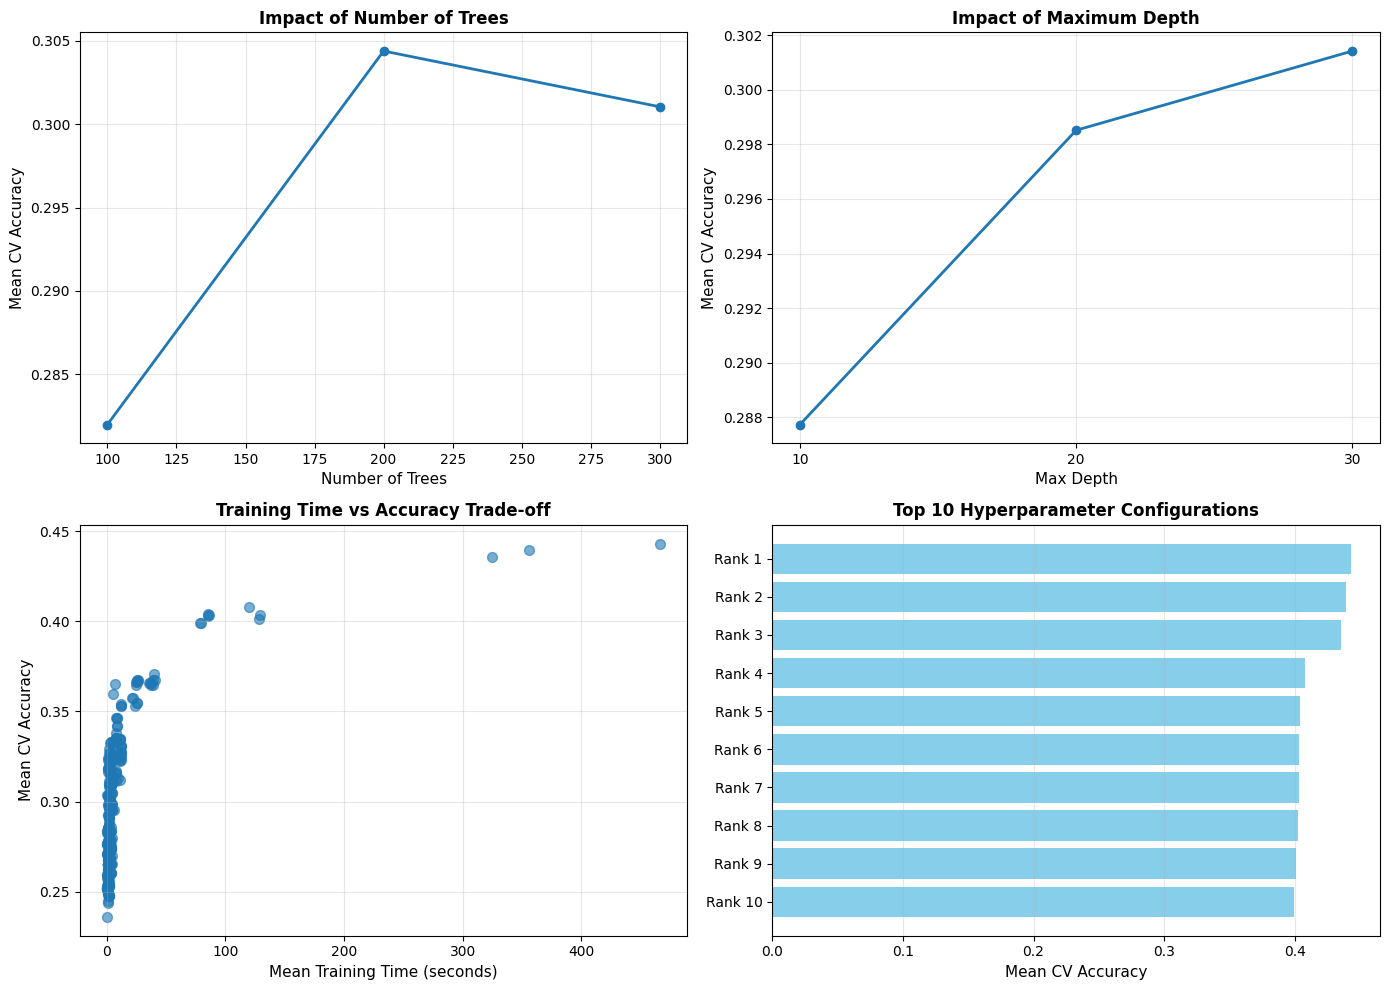

Best Balanced CV Accuracy: 0.4431
Best Parameters Found:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300


In [ ]:

top_results = rf_results_df.nsmallest(10, 'rank_test_score')[[
    'params', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'rank_test_score'
]]

for idx, (i, row) in enumerate(top_results.iterrows()):
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean CV Accuracy: {row['mean_test_score']:.4f} ")
    print(f"Mean Training Time: {row['mean_fit_time']:.2f}s")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Effect of n_estimators
n_est_data = rf_results_df.groupby('param_n_estimators').agg({
    'mean_test_score': 'mean',
    'mean_fit_time': 'mean'
})
axes[0, 0].plot(n_est_data.index, n_est_data['mean_test_score'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Number of Trees', fontsize=11)
axes[0, 0].set_ylabel('Mean CV Accuracy', fontsize=11)
axes[0, 0].set_title('Impact of Number of Trees', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

#Effect of max_depth
depth_data = rf_results_df.groupby('param_max_depth')['mean_test_score'].mean().sort_index()
axes[0, 1].plot(range(len(depth_data)), depth_data.values, marker='o', linewidth=2)
axes[0, 1].set_xticks(range(len(depth_data)))
axes[0, 1].set_xticklabels([str(x) if x is not None else 'None' for x in depth_data.index])
axes[0, 1].set_xlabel('Max Depth', fontsize=11)
axes[0, 1].set_ylabel('Mean CV Accuracy', fontsize=11)
axes[0, 1].set_title('Impact of Maximum Depth', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

#Runtime vs Accuracy trade-off
axes[1, 0].scatter(rf_results_df['mean_fit_time'], rf_results_df['mean_test_score'],
                   alpha=0.6, s=50)
axes[1, 0].set_xlabel('Mean Training Time (seconds)', fontsize=11)
axes[1, 0].set_ylabel('Mean CV Accuracy', fontsize=11)
axes[1, 0].set_title('Training Time vs Accuracy Trade-off', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

#Top 10 configurations
top_10_scores = top_results['mean_test_score'].values
axes[1, 1].barh(range(10, 0, -1), top_10_scores, color='skyblue')
axes[1, 1].set_yticks(range(10, 0, -1))
axes[1, 1].set_yticklabels([f'Rank {i}' for i in range(1, 11)])
axes[1, 1].set_xlabel('Mean CV Accuracy', fontsize=11)
axes[1, 1].set_title('Top 10 Hyperparameter Configurations', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

#Evaluate best model on test set
print(f"Best Balanced CV Accuracy: {best_cv_score_rf:.4f}")
print("Best Parameters Found:")
for k, v in best_params_rf.items():
  print(f"  {k}: {v}")


### Fully connected neural network

In [ ]:

subset_size = 20000
X_train_subset = X_train_normalized[:subset_size]
y_train_subset = y_train[:subset_size]

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

start_time = time.time()
mlp_tuner.search(
    X_train_mlp, y_train_mlp,
    validation_data=(X_valid_mlp, y_valid_mlp),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
tuning_time = time.time() - start_time

best_hps = mlp_tuner.get_best_hyperparameters()[0]
best_model = mlp_tuner.get_best_models()[0]

print(f"Best hyperparameters:")
print(f"Layers: {best_hps.get('num_layers')}")
print(f"Units: {best_hps.get('units_1')}")
print(f"Activation: {best_hps.get('activation_1')}")
print(f"Dropout: {best_hps.get('dropout_1')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 20 Complete [00h 00m 55s]
val_accuracy: 0.2635999917984009

Best val_accuracy So Far: 0.49380001425743103
Total elapsed time: 00h 47m 20s
Best hyperparameters:
Layers: 1
Units: 128
Activation: relu
Dropout: 0.2
Learning rate: 0.0001


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Analysis of FNN Hyperparameter tuning

Results summary
Results in mlp_tuning/cifar10_mlp
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
num_layers: 1
units_1: 128
activation_1: relu
dropout_1: 0.2
learning_rate: 0.0001
Score: 0.49380001425743103

Trial 13 summary
Hyperparameters:
num_layers: 1
units_1: 512
activation_1: relu
dropout_1: 0.4
learning_rate: 1e-05
units_2: 128
activation_2: tanh
dropout_2: 0.3
Score: 0.49140000343322754

Trial 18 summary
Hyperparameters:
num_layers: 1
units_1: 128
activation_1: relu
dropout_1: 0.2
learning_rate: 0.0001
units_2: 512
activation_2: tanh
dropout_2: 0.2
Score: 0.4828000068664551

Trial 16 summary
Hyperparameters:
num_layers: 1
units_1: 256
activation_1: relu
dropout_1: 0.3
learning_rate: 1e-05
units_2: 128
activation_2: relu
dropout_2: 0.3
Score: 0.48159998655319214

Trial 00 summary
Hyperparameters:
num_layers: 1
units_1: 256
activation_1: tanh
dropout_1: 0.3
learning_rate: 0.0001
Score: 0.4812000095844269

Trial 07 summary

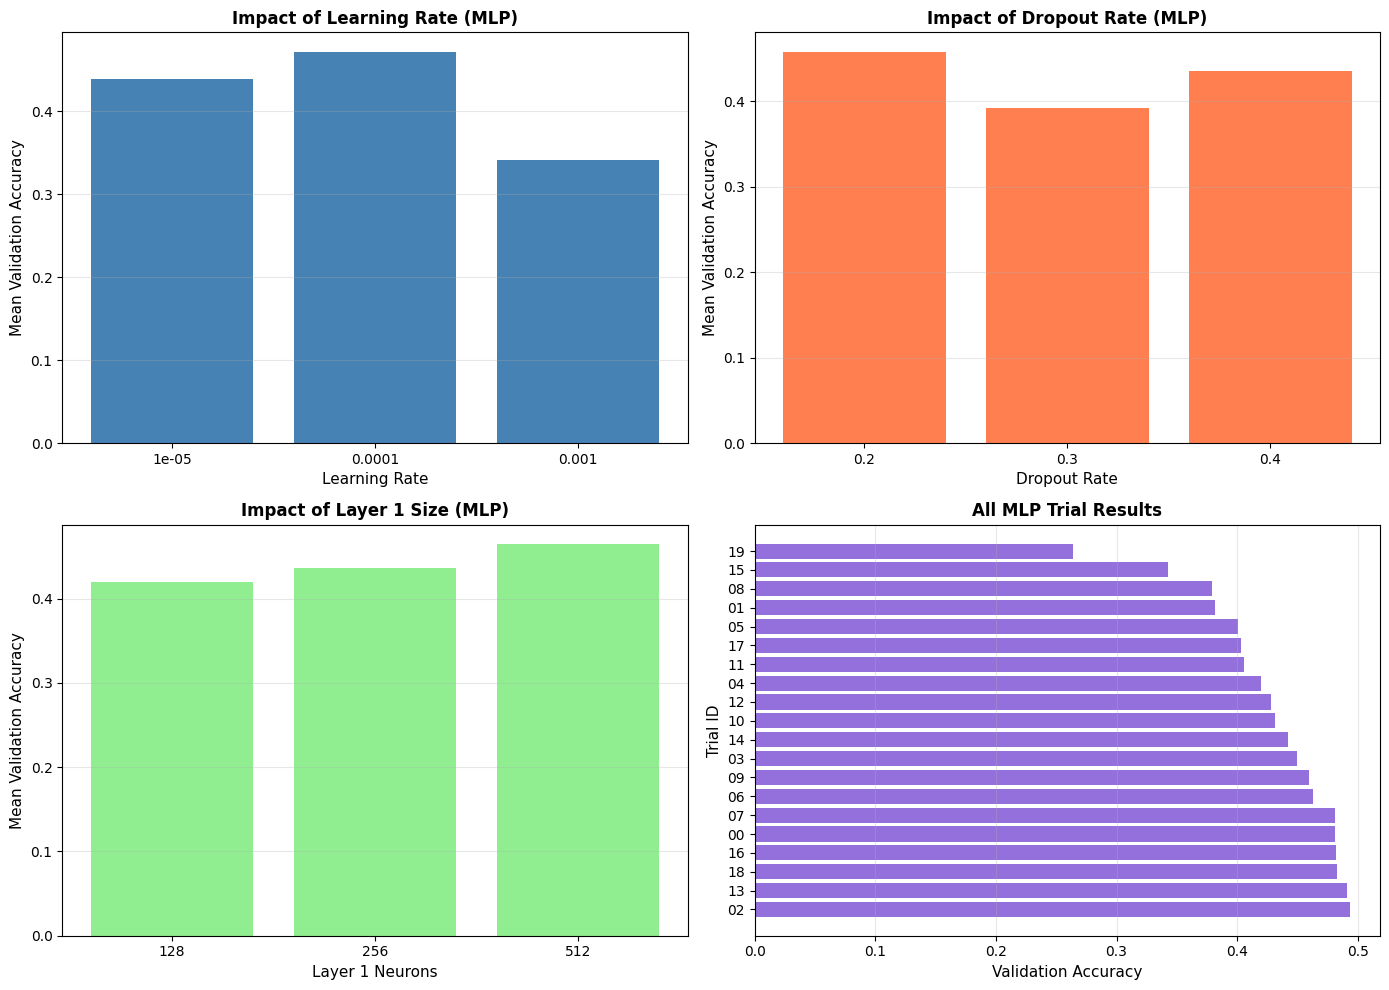


Best Trial (ID: 02):
Validation Accuracy: 0.4938
Units: 128
Dropout Rate: 0.2
Learning Rate: 0.0001

Hyperparameter Impact Analysis:
Impact of Layer 1 Size: 512 (best: 0.4643)
Dropout Rate: 0.2 (best: 0.4580)
Learning Rate: 0.0001 (best: 0.4717)

Performance Statistics:
Best Accuracy: 0.4938
Mean Accuracy: 0.4292
Std Accuracy: 0.0577
Min Accuracy: 0.2636


In [ ]:
mlp_tuner.results_summary()

mlp_trials = []
for trial_id, trial in mlp_tuner.oracle.trials.items():
    mlp_trials.append({
        'trial_id': trial.trial_id,
        'val_accuracy': trial.score if trial.score is not None else 0,
        'units_layer1': trial.hyperparameters.values.get('units_1'),
        'units_layer2': trial.hyperparameters.values.get('units_2'),
        'dropout': trial.hyperparameters.values.get('dropout_1'),
        'learning_rate': trial.hyperparameters.values.get('learning_rate')
    })

mlp_results_df = pd.DataFrame(mlp_trials).sort_values('val_accuracy', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Learning rate impact
lr_effect = mlp_results_df.groupby('learning_rate')['val_accuracy'].mean().sort_index()
axes[0, 0].bar(range(len(lr_effect)), lr_effect.values, color='steelblue')
axes[0, 0].set_xticks(range(len(lr_effect)))
axes[0, 0].set_xticklabels([f'{x}' for x in lr_effect.index])
axes[0, 0].set_xlabel('Learning Rate', fontsize=11)
axes[0, 0].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[0, 0].set_title('Impact of Learning Rate (MLP)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

#Dropout impact
dropout_effect = mlp_results_df.groupby('dropout')['val_accuracy'].mean().sort_index()
axes[0, 1].bar(range(len(dropout_effect)), dropout_effect.values, color='coral')
axes[0, 1].set_xticks(range(len(dropout_effect)))
axes[0, 1].set_xticklabels([f'{x}' for x in dropout_effect.index])
axes[0, 1].set_xlabel('Dropout Rate', fontsize=11)
axes[0, 1].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[0, 1].set_title('Impact of Dropout Rate (MLP)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

#Layer 1 size impact
units1_effect = mlp_results_df.groupby('units_layer1')['val_accuracy'].mean().sort_index()
axes[1, 0].bar(range(len(units1_effect)), units1_effect.values, color='lightgreen')
axes[1, 0].set_xticks(range(len(units1_effect)))
axes[1, 0].set_xticklabels([f'{int(x)}' for x in units1_effect.index])
axes[1, 0].set_xlabel('Layer 1 Neurons', fontsize=11)
axes[1, 0].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[1, 0].set_title('Impact of Layer 1 Size (MLP)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

#All trials comparison
axes[1, 1].barh(mlp_results_df['trial_id'], mlp_results_df['val_accuracy'], color='mediumpurple')
axes[1, 1].set_xlabel('Validation Accuracy', fontsize=11)
axes[1, 1].set_ylabel('Trial ID', fontsize=11)
axes[1, 1].set_title('All MLP Trial Results', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

#Best hyperparameters
best_trial = mlp_results_df.iloc[0]
print(f"\nBest Trial (ID: {best_trial['trial_id']}):")
print(f"Validation Accuracy: {best_trial['val_accuracy']:.4f}")
print(f"Units: {best_trial['units_layer1']}")
print(f"Dropout Rate: {best_trial['dropout']}")
print(f"Learning Rate: {best_trial['learning_rate']}")

#Hyperparameter impact analysis
print(f"\nHyperparameter Impact Analysis:")
print(f"Impact of Layer 1 Size: {units1_effect.idxmax()} (best: {units1_effect.max():.4f})")
print(f"Dropout Rate: {dropout_effect.idxmax()} (best: {dropout_effect.max():.4f})")
print(f"Learning Rate: {lr_effect.idxmax()} (best: {lr_effect.max():.4f})")

#Performance statistics
print(f"\nPerformance Statistics:")
print(f"Best Accuracy: {mlp_results_df['val_accuracy'].max():.4f}")
print(f"Mean Accuracy: {mlp_results_df['val_accuracy'].mean():.4f}")
print(f"Std Accuracy: {mlp_results_df['val_accuracy'].std():.4f}")
print(f"Min Accuracy: {mlp_results_df['val_accuracy'].min():.4f}")


### Convolutional neural network

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

subset_size = 20000
X_train_subset = X_train_mlp[:subset_size]
y_train_subset = y_train_mlp[:subset_size]

start_time = time.time()
cnn_tuner.search(
    X_train_subset, y_train_subset,
    validation_data=(X_valid_mlp, y_valid_mlp),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
cnn_tuning_time = time.time() - start_time

cnn_best_hps = cnn_tuner.get_best_hyperparameters()[0]
cnn_best_model = cnn_tuner.get_best_models()[0]

print("\nBest hyperparameters:")
print(f"Dense units: {cnn_best_hps.get('dense_units')}")
print(f"Learning rate: {cnn_best_hps.get('learning_rate')}\n")

cnn_results_df = pd.DataFrame(cnn_tuner.oracle.get_best_trials()[0].metrics.get_history('val_accuracy'))
print(f"Tuning completed in {cnn_tuning_time/60:.2f} minutes")

Trial 20 Complete [00h 02m 12s]
val_accuracy: 0.6863999962806702

Best val_accuracy So Far: 0.8108000159263611
Total elapsed time: 01h 01m 44s

Best hyperparameters:
Dense units: 512
Learning rate: 0.001

Tuning completed in 61.74 minutes


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Analysis of CNN Tuning


All Trial Results (sorted by validation accuracy):
trial_id  val_accuracy  dense_units  dropout_rate  learning_rate
      04        0.8108          512           0.2         0.0010
      01        0.8050          256           0.2         0.0010
      16        0.8004          256           0.4         0.0010
      03        0.7926          512           0.5         0.0005
      08        0.7924          512           0.5         0.0010
      13        0.7922          512           0.4         0.0005
      18        0.7886          256           0.3         0.0010
      17        0.7884          256           0.5         0.0005
      07        0.7862          256           0.2         0.0005
      02        0.7862          256           0.5         0.0010
      09        0.7772          512           0.2         0.0005
      05        0.7744          256           0.3         0.0005
      10        0.7614          512           0.3         0.0010
      00        0.7512          256   

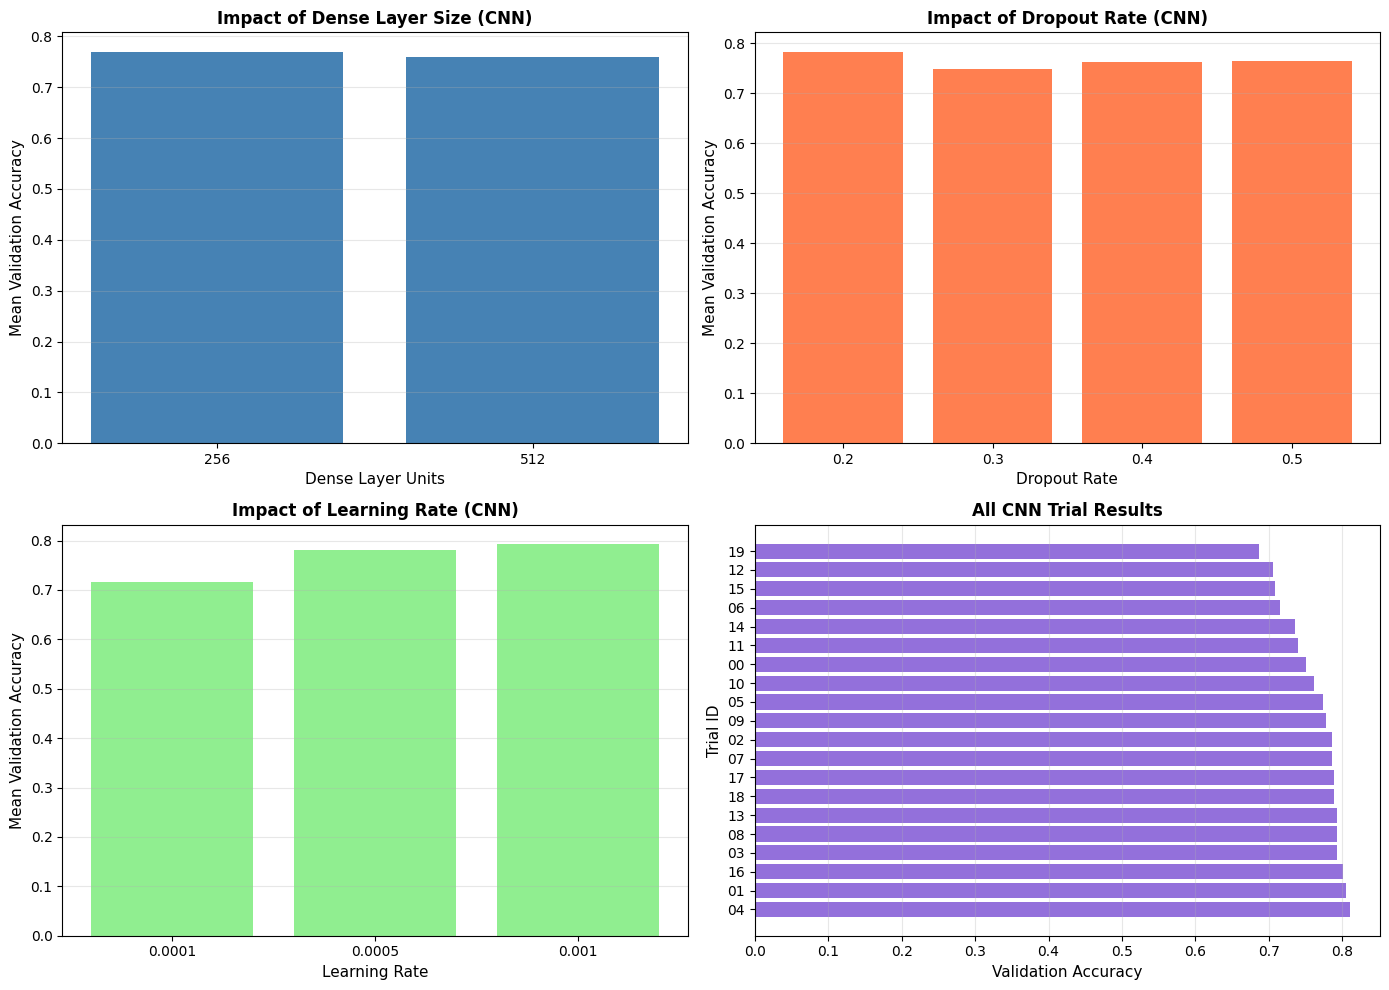


Best Trial (ID: 04):
Validation Accuracy: 0.8108
Dense Units: 512
Dropout Rate: 0.2
Learning Rate: 0.001

Hyperparameter Impact Analysis:
Dense Units: 256 (best: 0.7695)
Dropout Rate: 0.2 (best: 0.7831)
Learning Rate: 0.001 (best: 0.7921)

Performance Statistics:
Best Accuracy: 0.8108
Mean Accuracy: 0.7649
Std Accuracy: 0.0374
Min Accuracy: 0.6864


In [ ]:
cnn_trials = []
for trial_id, trial in cnn_tuner.oracle.trials.items():
    cnn_trials.append({
        'trial_id': trial.trial_id,
        'val_accuracy': trial.score if trial.score is not None else 0,
        'dense_units': trial.hyperparameters.values.get('dense_units'),
        'dropout_rate': trial.hyperparameters.values.get('dropout_rate'),
        'learning_rate': trial.hyperparameters.values.get('learning_rate')
    })

cnn_results_df = pd.DataFrame(cnn_trials).sort_values('val_accuracy', ascending=False)

print("\nAll Trial Results (sorted by validation accuracy):")

print(cnn_results_df.to_string(index=False))

#Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Dense layer size impact
dense_effect = cnn_results_df.groupby('dense_units')['val_accuracy'].mean().sort_index()
axes[0, 0].bar(range(len(dense_effect)), dense_effect.values, color='steelblue')
axes[0, 0].set_xticks(range(len(dense_effect)))
axes[0, 0].set_xticklabels([f'{int(x)}' for x in dense_effect.index])
axes[0, 0].set_xlabel('Dense Layer Units', fontsize=11)
axes[0, 0].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[0, 0].set_title('Impact of Dense Layer Size (CNN)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

#Dropout rate impact
dropout_effect = cnn_results_df.groupby('dropout_rate')['val_accuracy'].mean().sort_index()
axes[0, 1].bar(range(len(dropout_effect)), dropout_effect.values, color='coral')
axes[0, 1].set_xticks(range(len(dropout_effect)))
axes[0, 1].set_xticklabels([f'{x}' for x in dropout_effect.index])
axes[0, 1].set_xlabel('Dropout Rate', fontsize=11)
axes[0, 1].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[0, 1].set_title('Impact of Dropout Rate (CNN)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

#Learning rate impact
lr_effect = cnn_results_df.groupby('learning_rate')['val_accuracy'].mean().sort_index()
axes[1, 0].bar(range(len(lr_effect)), lr_effect.values, color='lightgreen')
axes[1, 0].set_xticks(range(len(lr_effect)))
axes[1, 0].set_xticklabels([f'{x}' for x in lr_effect.index])
axes[1, 0].set_xlabel('Learning Rate', fontsize=11)
axes[1, 0].set_ylabel('Mean Validation Accuracy', fontsize=11)
axes[1, 0].set_title('Impact of Learning Rate (CNN)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

#All trials comparison
axes[1, 1].barh(cnn_results_df['trial_id'], cnn_results_df['val_accuracy'], color='mediumpurple')
axes[1, 1].set_xlabel('Validation Accuracy', fontsize=11)
axes[1, 1].set_ylabel('Trial ID', fontsize=11)
axes[1, 1].set_title('All CNN Trial Results', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


#Best hyperparameters
best_trial = cnn_results_df.iloc[0]
print(f"\nBest Trial (ID: {best_trial['trial_id']}):")
print(f"Validation Accuracy: {best_trial['val_accuracy']:.4f}")
print(f"Dense Units: {best_trial['dense_units']}")
print(f"Dropout Rate: {best_trial['dropout_rate']}")
print(f"Learning Rate: {best_trial['learning_rate']}")

#Hyperparameter impact analysis
print(f"\nHyperparameter Impact Analysis:")
print(f"Dense Units: {dense_effect.idxmax()} (best: {dense_effect.max():.4f})")
print(f"Dropout Rate: {dropout_effect.idxmax()} (best: {dropout_effect.max():.4f})")
print(f"Learning Rate: {lr_effect.idxmax()} (best: {lr_effect.max():.4f})")

#Performance statistics
print(f"\nPerformance Statistics:")
print(f"Best Accuracy: {cnn_results_df['val_accuracy'].max():.4f}")
print(f"Mean Accuracy: {cnn_results_df['val_accuracy'].mean():.4f}")
print(f"Std Accuracy: {cnn_results_df['val_accuracy'].std():.4f}")
print(f"Min Accuracy: {cnn_results_df['val_accuracy'].min():.4f}")


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course: Random Forest Classifier

In [ ]:
"""Best Parameters Found:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300"""

best_params_rf = {
  "max_depth": 30,
  "max_features": "sqrt",
  "min_samples_leaf": 1,
  "min_samples_split": 2,
  "n_estimators": 300
}
rf_final = RandomForestClassifier(**best_params_rf)

start_time = time.time()
rf_final.fit(X_train_normalized, y_train)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Training completed in 1192.71 seconds (19.88 minutes)


### RF CLassifier Final Model Analysis

Training Accuracy: 0.9999
Test Accuracy: 0.4886
Overfitting: 51.13%

              precision    recall  f1-score   support

    airplane       0.55      0.56      0.56      1000
  automobile       0.55      0.56      0.55      1000
        bird       0.43      0.36      0.39      1000
         cat       0.37      0.27      0.31      1000
        deer       0.43      0.41      0.42      1000
         dog       0.45      0.42      0.43      1000
        frog       0.47      0.60      0.52      1000
       horse       0.54      0.49      0.52      1000
        ship       0.59      0.62      0.60      1000
       truck       0.48      0.58      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000


Per Class Accuracy
airplane    : 0.5610 (56.10%)
automobile  : 0.5600 (56.00%)
bird        : 0.3650 (36.50%)
cat         : 0.2730 (27.30%)
deer        : 0.4080 (40.80%)
do

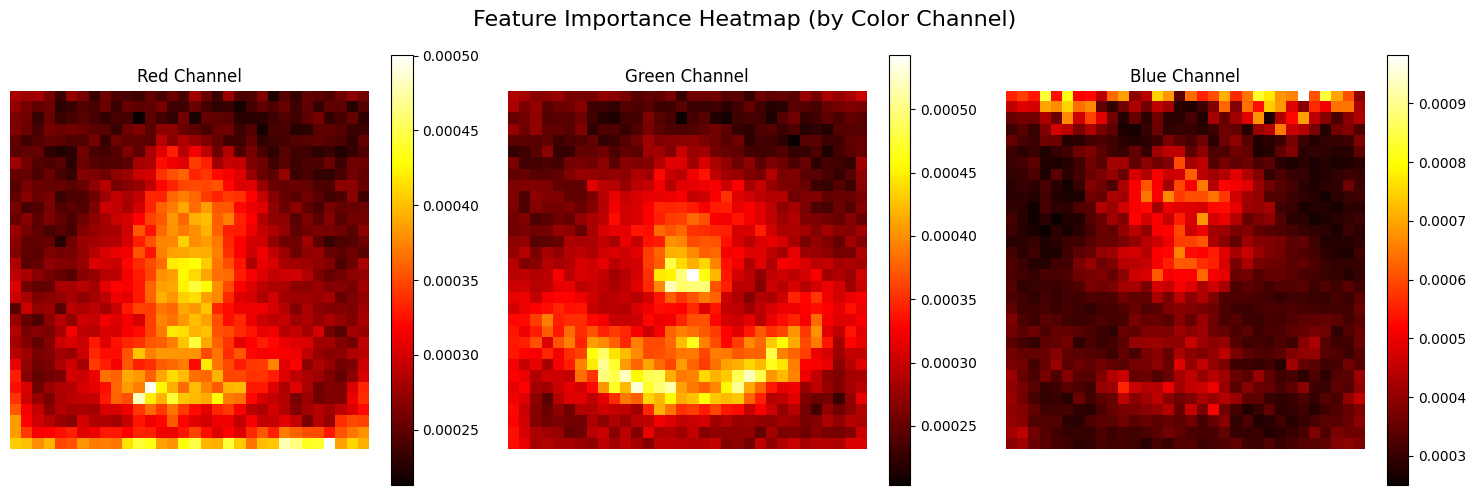

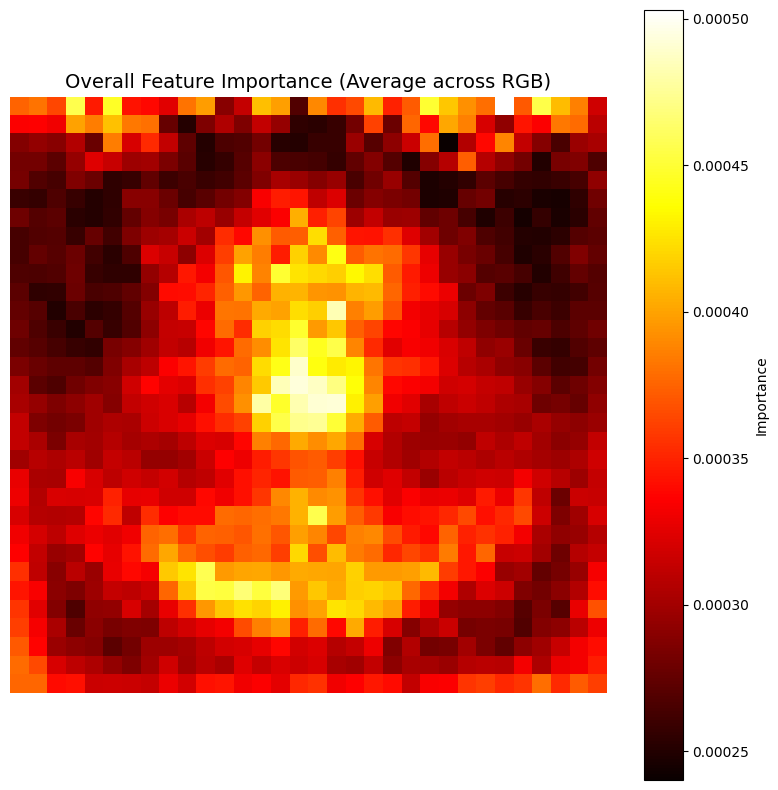

In [ ]:
#test accuracy
y_train_pred_final = rf_final.predict(X_train_normalized)
y_test_pred_final = rf_final.predict(X_test_normalized)

rf_train_accuracy_final = accuracy_score(y_train, y_train_pred_final)
rf_test_accuracy_final = accuracy_score(y_test, y_test_pred_final)

print(f"Training Accuracy: {rf_train_accuracy_final:.4f}")
print(f"Test Accuracy: {rf_test_accuracy_final:.4f}")
print(f"Overfitting: {(rf_train_accuracy_final - rf_test_accuracy_final)*100:.2f}%\n")


#Classification report and per class accuracy
print(classification_report(y_test, y_test_pred_final, target_names=class_names))

print("\nPer Class Accuracy")
cm_final = confusion_matrix(y_test, y_test_pred_final)
class_accuracies = cm_final.diagonal() / cm_final.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
    print(f"{class_name:12s}: {acc:.4f} ({acc*100:.2f}%)")


feature_importance = rf_final.feature_importances_
importance_image = feature_importance.reshape(32, 32, 3)
#colour importance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Feature Importance Heatmap (by Color Channel)', fontsize=16)

channel_names = ['Red', 'Green', 'Blue']
for i in range(3):
    im = axes[i].imshow(importance_image[:, :, i], cmap='hot', interpolation='nearest')
    axes[i].set_title(f'{channel_names[i]} Channel')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

importance_rgb = feature_importance.reshape(32, 32, 3).mean(axis=2)
plt.figure(figsize=(8, 8))
plt.imshow(importance_rgb, cmap='hot', interpolation='nearest')
plt.title('Overall Feature Importance (Average across RGB)', fontsize=14)
plt.colorbar(label='Importance')
plt.axis('off')
plt.tight_layout()
plt.show()

### Fully connected neural network

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

"""Layers: 1
Units: 128
Activation: relu
Dropout: 0.2
Learning rate: 0.0001"""
nn = kt.HyperParameters()
nn.Fixed('num_layers', 2)
nn.Fixed('units_1', 128)
nn.Fixed('activation_1', 'relu')
nn.Fixed('dropout_1', 0.2)
nn.Fixed('units_2', 128)
nn.Fixed('activation_2', 'relu')
nn.Fixed('dropout_2', 0.2)
nn.Fixed('learning_rate', 0.0001)
nn_model = build_fc_model(nn)

print(f"Summary: {nn_model.summary()}")
print(f"Total parameters: {nn_model.count_params()}\n")

start_time = time.time()
nn_history = nn_model.fit(
    X_train_mlp, y_train_mlp,
    validation_data=(X_valid_mlp, y_valid_mlp),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

nn_test_loss, nn_test_acc = nn_model.evaluate(X_test_nn, y_test, verbose=0)

print(f"\nTest Accuracy: {nn_test_acc:.4f}")
print(f"Test Loss: {nn_test_loss:.4f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,146 (1.57 MB)

 Trainable params: 411,146 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Summary: None
Total parameters: 411146

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2114 - loss: 2.1254 - val_accuracy: 0.3460 - val_loss: 1.8496
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3196 - loss: 1.8779 - val_accuracy: 0.3884 - val_loss: 1.7435
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3570 - loss: 1.7927 - val_accuracy: 0.3898 - val_loss: 1.7055
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3717 - loss: 1.7512 - val_accuracy: 0.4162 - val_loss: 1.6574
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3916 - loss: 1.7069 - val_accuracy: 0.4200 - val_loss: 1.6254
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4039 - loss: 1.6809 - val_accuracy: 0.4264 - val_loss: 1.6106
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4140 - loss: 1.6558 - val_accuracy: 0.4320 - val_loss: 1.5890
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 

### FNN Final Model Analysis

Test Accuracy: 0.4892
Test Loss: 1.4401


Classification Report:
              precision    recall  f1-score   support

    airplane       0.58      0.52      0.55      1000
  automobile       0.64      0.56      0.59      1000
        bird       0.37      0.36      0.36      1000
         cat       0.36      0.29      0.33      1000
        deer       0.40      0.41      0.41      1000
         dog       0.44      0.34      0.39      1000
        frog       0.48      0.57      0.52      1000
       horse       0.51      0.58      0.55      1000
        ship       0.60      0.64      0.62      1000
       truck       0.49      0.61      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



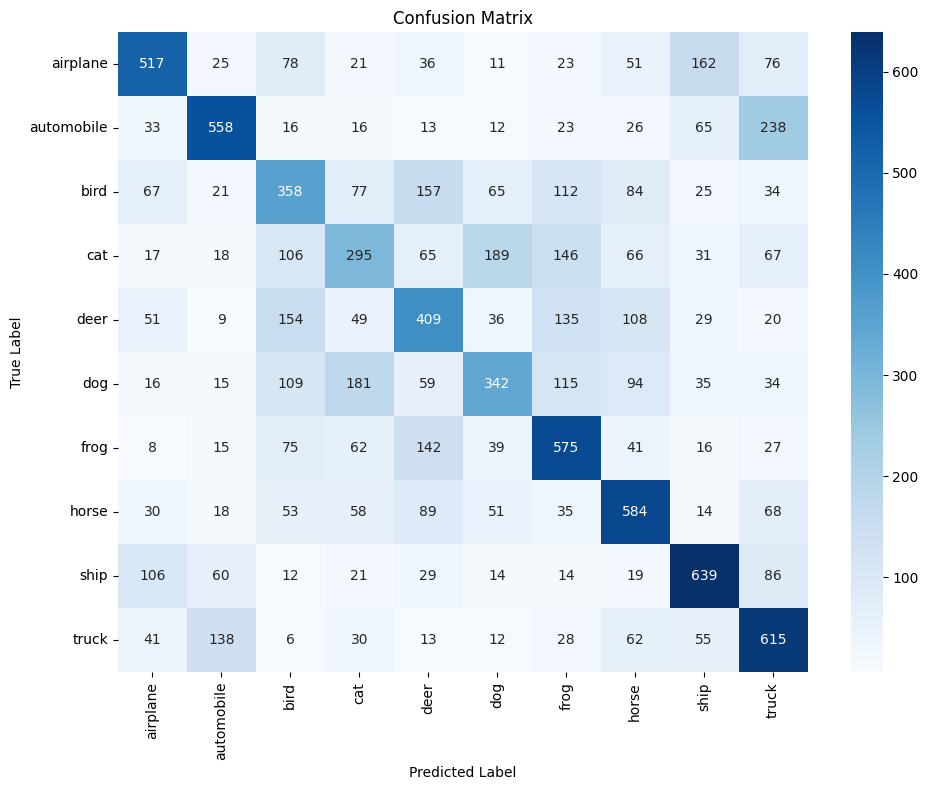

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


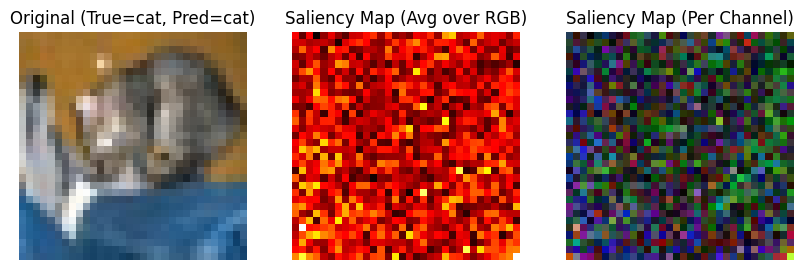

In [ ]:
#Accuracy
print(f"Test Accuracy: {nn_test_acc:.4f}")
print(f"Test Loss: {nn_test_loss:.4f}\n")

y_pred_mlp = nn_model.predict(X_test_nn, verbose=0)
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp_classes, target_names=class_names))

#Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

#Image Analysis
image = X_test_nn[0:1]
true_label = y_test[0]
pred_label = np.argmax(nn_model.predict(image), axis=1)[0]
image_tensor = tf.convert_to_tensor(image)

with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    preds = nn_model(image_tensor)
    class_channel = preds[:, pred_label]

grads = tape.gradient(class_channel, image_tensor)
grads = tf.math.abs(grads)
grads = grads / tf.reduce_max(grads)
saliency = grads.numpy()[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(image[0])
plt.title(f"Original (True={class_names[true_label]}, Pred={class_names[pred_label]})")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency.mean(axis=-1), cmap='hot')
plt.title("Saliency Map (Avg over RGB)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(saliency)
plt.title("Saliency Map (Per Channel)")
plt.axis('off')
plt.show()

### Convolutional neural network

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

"""Best Trial (ID: 04):
Validation Accuracy: 0.8108
Dense Units: 512
Dropout Rate: 0.2
Learning Rate: 0.001"""
cnn = kt.HyperParameters()
cnn.Fixed('dense_units', 512)
cnn.Fixed('learning_rate', 0.001)
cnn.Fixed('dropout_rate', 0.2)
cnn_model = build_cnn_model(cnn)
print(f"Summary: {cnn_model.summary()}")
print(f"Total parameters: {cnn_model.count_params()}\n")
start_time = time.time()

cnn_history = cnn_model.fit(
    X_train_mlp, y_train_mlp,
    validation_data=(X_valid_mlp, y_valid_mlp),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_nn, y_test, verbose=0)
print(f"\nTest Accuracy: {cnn_test_acc:.4f}")
print(f"Test Loss: {cnn_test_loss:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,082 (1.37 MB)

 Trainable params: 358,634 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

Summary: None
Total parameters: 359082

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.3897 - loss: 1.6477 - val_accuracy: 0.3858 - val_loss: 2.0857
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5900 - loss: 1.1448 - val_accuracy: 0.5688 - val_loss: 1.2647
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6480 - loss: 0.9934 - val_accuracy: 0.6380 - val_loss: 1.1027
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6953 - loss: 0.8756 - val_accuracy: 0.6920 - val_loss: 0.8867
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7172 - loss: 0.8078 - val_accuracy: 0.7240 - val_loss: 0.8017
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7391 - loss: 0.7555 - val_accuracy: 0.7462 - val_loss: 0.7440
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7577 - loss: 0.6995 - val_accuracy: 0.7064 - val_loss: 0.8820
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/st

### CNN Final Model Analysis


Test Accuracy: 0.8341
Test Loss: 0.4915

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.87      0.85      1000
  automobile       0.90      0.92      0.91      1000
        bird       0.85      0.75      0.80      1000
         cat       0.68      0.73      0.71      1000
        deer       0.84      0.81      0.82      1000
         dog       0.76      0.79      0.78      1000
        frog       0.87      0.86      0.86      1000
       horse       0.92      0.84      0.88      1000
        ship       0.94      0.86      0.90      1000
       truck       0.79      0.92      0.85      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



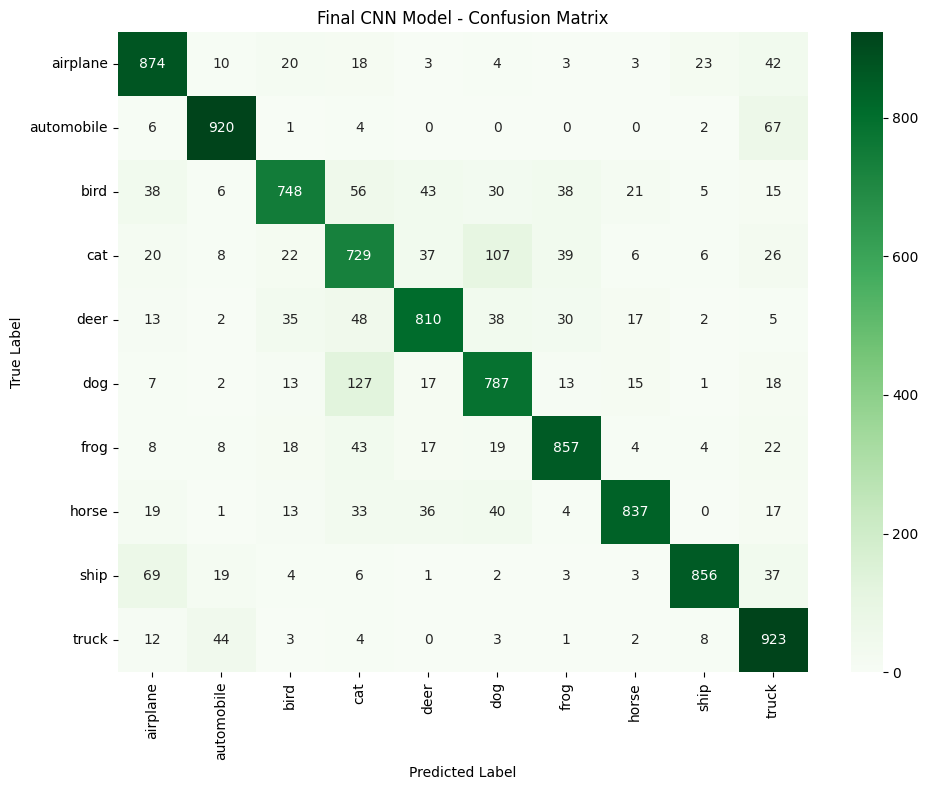

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


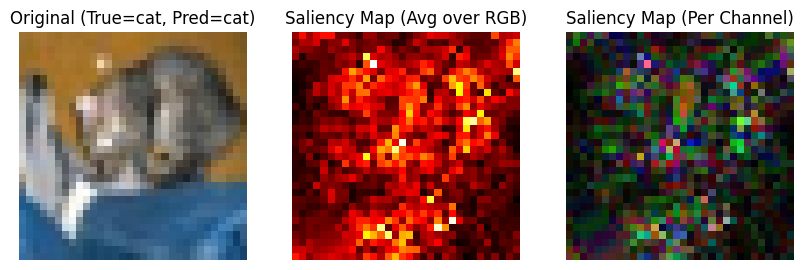

In [ ]:
print(f"\nTest Accuracy: {cnn_test_acc:.4f}")
print(f"Test Loss: {cnn_test_loss:.4f}")

# Get predictions
y_pred_cnn = cnn_model.predict(X_test_nn, verbose=0)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cnn_classes, target_names=class_names))

# Confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final CNN Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


#Image Display
image = X_test_nn[0:1]
true_label = y_test[0]
pred_label = np.argmax(cnn_model.predict(image), axis=1)[0]
image_tensor = tf.convert_to_tensor(image)

with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    preds = cnn_model(image_tensor)
    class_channel = preds[:, pred_label]

grads = tape.gradient(class_channel, image_tensor)
grads = tf.math.abs(grads)
grads = grads / tf.reduce_max(grads)
saliency = grads.numpy()[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(image[0])
plt.title(f"Original (True={class_names[true_label]}, Pred={class_names[pred_label]})")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency.mean(axis=-1), cmap='hot')
plt.title("Saliency Map (Avg over RGB)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(saliency)
plt.title("Saliency Map (Per Channel)")
plt.axis('off')
plt.show()